In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('sp500sub.csv',index_col='Date',parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [4]:
goog = df[df['Name'] == 'GOOG']['Close']

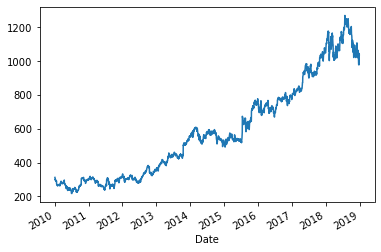

In [5]:
goog.plot();

In [6]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [7]:
model = pm.auto_arima(train,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16270.771, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16270.383, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16269.726, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16269.492, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16271.123, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16268.077, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16267.935, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16268.277, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16266.968, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16264.983, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16266.925, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16268.907, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16265.470, Time=0.14 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 5.907 seconds


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8127.491
Date:                Tue, 14 Jun 2022   AIC                          16264.983
Time:                        19:17:50   BIC                          16293.536
Sample:                             0   HQIC                         16275.409
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3104      0.198      1.571      0.116      -0.077       0.698
ar.L1          0.0378      0.012      3.152      0.002       0.014       0.061
ar.L2         -0.0410      0.013     -3.241      0.001      -0.066      -0.016
ar.L3          0.0488      0.012      4.031      0.000       0.025       0.073
sigma2        85.1623      1.033     82.421      0.000      83.137      87.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11790.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [11]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index,
                    confint[:,0],confint[:,1],
                    color='red',alpha=0.3)
    ax.legend();

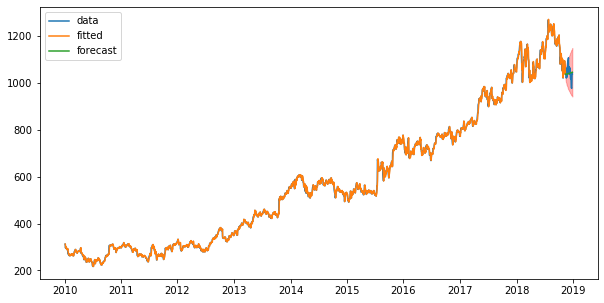

In [12]:
plot_result(model, goog, train, test)

In [14]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(test.index, test, label='data')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index,
                    confint[:,0],confint[:,1],
                    color='red',alpha=0.3)
    ax.legend();

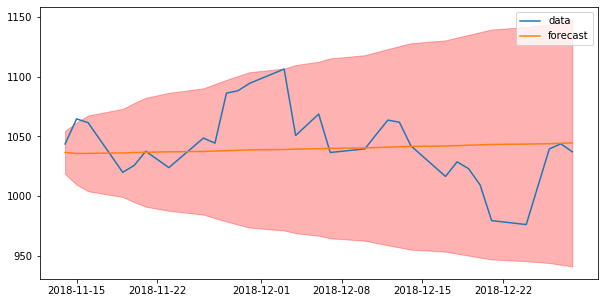

In [15]:
plot_test(model, test)

In [16]:
### forecast RMSE
def rmse(t, y):
    return np.sqrt(np.mean((t - y)**2))

In [17]:
print("ARIMA RMSE:", rmse(model.predict(Ntest), test))
print("Naive RMSE:", rmse(train.iloc[-1], test))

ARIMA RMSE: 30.436602026398194
Naive RMSE: 30.02950247726083


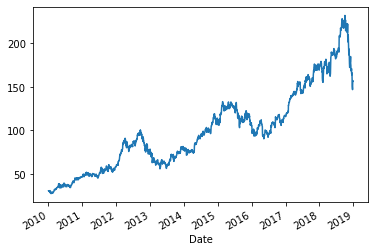

In [19]:
aapl = df[df['Name'] == 'AAPL']['Close']
aapl.plot();

In [20]:
train = aapl.iloc[:-Ntest]
test = aapl.iloc[-Ntest:]

In [21]:
model = pm.auto_arima(train,
                      error_action='ignore',
                      trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8570.296, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8575.329, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8574.709, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8574.392, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8577.622, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8571.650, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8571.332, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8572.500, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8572.527, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8574.574, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8570.852, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8570.880, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8579.289, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8572.973, Time=0.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4279.148
Date:                Tue, 14 Jun 2022   AIC                           8570.296
Time:                        19:39:04   BIC                           8604.560
Sample:                             0   HQIC                          8582.808
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0803      0.042      1.896      0.058      -0.003       0.163
ar.L1          0.3755      0.165      2.279      0.023       0.053       0.699
ar.L2         -0.4239      0.176     -2.407      0.016      -0.769      -0.079
ma.L1         -0.3433      0.172     -2.002      0.045      -0.679      -0.007
ma.L2          0.3579      0.183      1.958      0.050      -0.000       0.716
sigma2         2.7182      0.039     69.453      0.000       2.642       2.795
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6223.04
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.23   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

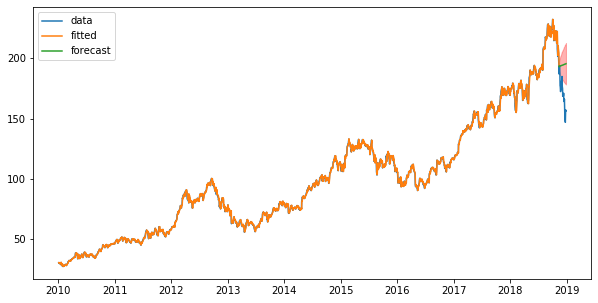

In [23]:
plot_result(model, aapl, train, test)

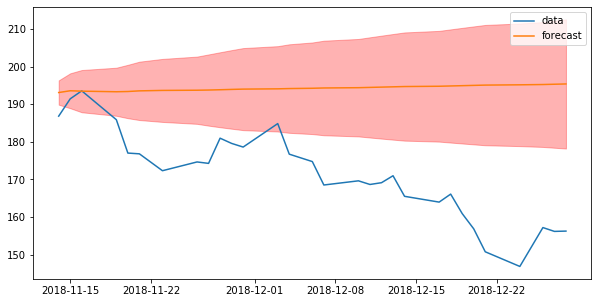

In [24]:
plot_test(model, test)

In [25]:
print("ARIMA RMSE:", rmse(model.predict(Ntest), test))
print("Naive RMSE:", rmse(train.iloc[-1], test))

ARIMA RMSE: 26.09496279093135
Naive RMSE: 24.027120586673743


In [26]:
ibm = df[df['Name'] == 'IBM']['Close']

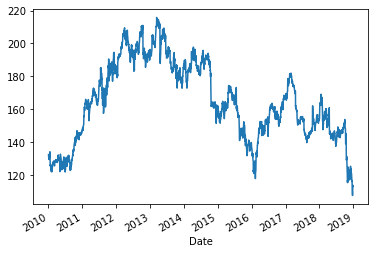

In [27]:
ibm.plot()

In [28]:
train = ibm.iloc[:-Ntest]
test = ibm.iloc[-Ntest:]

In [29]:
model = pm.auto_arima(train,
                      error_action='ignore',
                      trace=True,
                      suppress_warnings=True,
                      maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9442.954, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9436.082, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9437.603, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9437.589, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9434.097, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9439.637, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.250 seconds


In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4716.049
Date:                Tue, 14 Jun 2022   AIC                           9434.097
Time:                        19:42:19   BIC                           9439.808
Sample:                             0   HQIC                          9436.183
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.0067      0.055     72.559      0.000       3.898       4.115
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):              5352.76
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.77
Prob(H) (two-sided):                  0.03   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

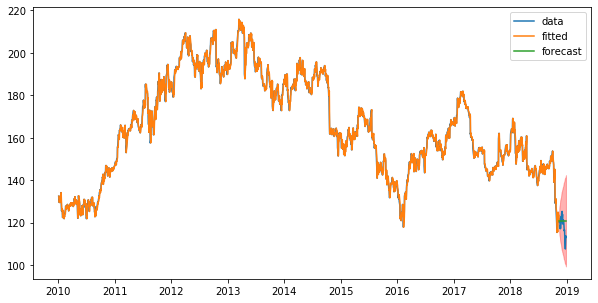

In [31]:
plot_result(model, ibm, train, test)

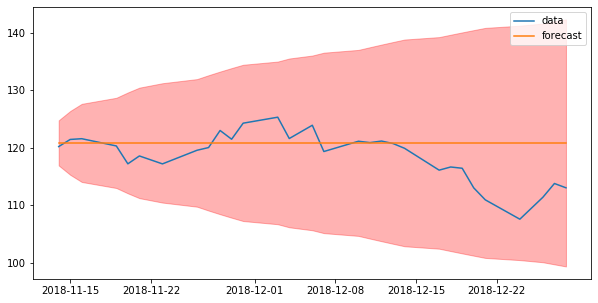

In [33]:
plot_test(model, test)

In [34]:
print("ARIMA RMSE:", rmse(model.predict(Ntest), test))
print("Naive RMSE:", rmse(train.iloc[-1], test))

ARIMA RMSE: 4.763157130051337
Naive RMSE: 4.763157130051337


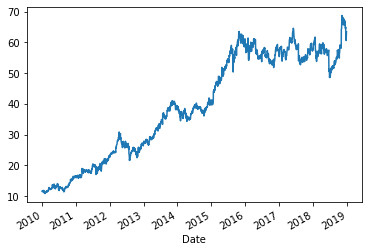

In [35]:
sbux = df[df['Name'] == 'SBUX']['Close']
sbux.plot();

In [36]:
train = sbux.iloc[:-Ntest]
test = sbux.iloc[-Ntest:]

In [37]:
model = pm.auto_arima(train, error_action='ignore',trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3858.919, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3851.895, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3853.862, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3853.860, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3854.154, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3855.861, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.162 seconds


In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1923.948
Date:                Tue, 14 Jun 2022   AIC                           3851.895
Time:                        19:45:34   BIC                           3863.317
Sample:                             0   HQIC                          3856.066
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0250      0.012      2.048      0.041       0.001       0.049
sigma2         0.3283      0.003     94.371      0.000       0.321       0.335
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             18901.16
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               3.80   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

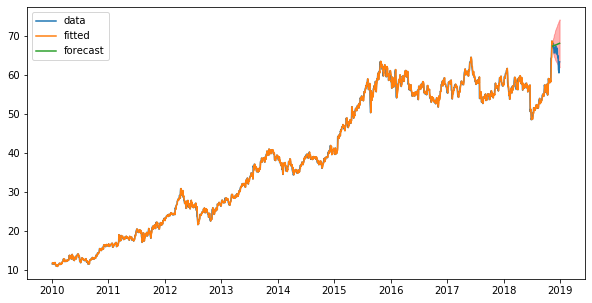

In [39]:
plot_result(model, sbux, train, test)

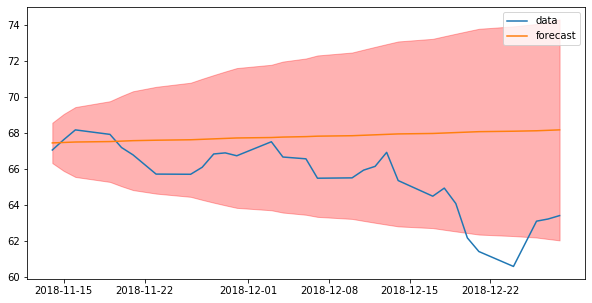

In [40]:
plot_test(model, test)

In [41]:
print("ARIMA RMSE:", rmse(model.predict(Ntest), test))
print("Naive RMSE:", rmse(train.iloc[-1], test))

ARIMA RMSE: 3.0949031428409435
Naive RMSE: 2.688938576340915
